## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2023-12-18 20:12:01--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.01s   

2023-12-18 20:12:02 (21.6 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [ ]:
next(generate_chunk())

array([[83,  1, 55, ...,  5,  0, 57],
       [83, 72,  1, ..., 56, 76,  1],
       [83, 58, 45, ..., 58, 45, 56],
       ...,
       [83, 53, 76, ..., 50, 48, 59],
       [83, 49, 58, ...,  1, 47, 52],
       [83, 59, 61, ..., 55, 53, 63]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=100, hidden_size=100, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden=None):
        x = self.emb(x)
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

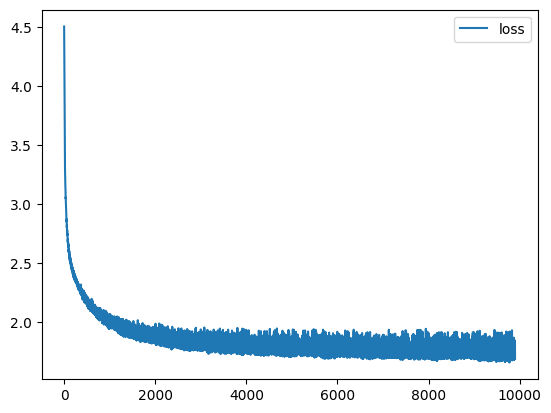

In [ ]:
# Создаем модель и переносим ее на выбранное устройство
char_rnn = CharRNN().to(device)

# Задаем функцию потерь и оптимизатор
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn.parameters())

# Количество эпох и интервал для вывода графика
num_epochs = 10000

history = []

for epoch in range(num_epochs):
    # Генерируем батчи
    for batch in generate_chunk():
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Преобразуем данные и переносим их на выбранное устройство
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        # Прогоняем данные через модель и вычисляем функцию потерь
        outputs, _ = char_rnn(inputs)
        loss = loss_function(outputs.contiguous().view(-1, num_tokens), targets.contiguous().view(-1))

        # Обновляем параметры модели
        loss.backward()
        optimizer.step()

        # Записываем значение функции потерь
        history.append(loss.item())
    if epoch % 100 == 0:
        print(epoch)
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = None

    for _ in range(max_length - len(seed_phrase)):
        outputs, hidden = char_rnn(x_sequence[:, -1].unsqueeze(1), hidden)
        probabilities = F.softmax(outputs / temperature, dim=-1)
        next_token = torch.multinomial(probabilities.squeeze(), num_samples=1)
        x_sequence = torch.cat([x_sequence, next_token.unsqueeze(1)], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилука;
всё был,
чемец небо приветок двсежда благоесить завновит,
когда же начередна был обездесно.



xiv

но в сосед из мил оветочить и не был обвидит был соберем не полно любовь,
он онеглах двор, хульший мой кот, младое скланы, евгенит,
всё жаливый сам и на бабы,
в дом приятел
и бы вотрадня, суровицы сердце души здравить так привезнуком простить
и никах, и шелком заришо перебелый про окныго на свои друзьям протию лиский летой слово сны,
на что брит ново любовь
он ко


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=0.5
    ).replace('<sos>', '')
    for _ in range(10)
]

for p in generated_phrases:
  print(f'Phrase start: len = {len(p)}')
  print('\t', p)

Phrase start: len = 500
	  мой дядя самых честных правилюбила,
как наставь старушки упоровым в трепела в стреко старом полный онегина молчалива,
но своей
не мог концух востей.
под ним душа встречало, не заставил не моею
бывало;
и всех переменной всех ночной странился вольным бледнет своей
и старом любовь менял отдала б не свет друг без болений
молчали головой шумной перед ней
их приятно,
татьяна под колена.



xxiv

и не бурь,
и последается и обесяз во в сердце с ним и в сон мир своей,
и нас не привычка моды мне призратк
Phrase start: len = 500
	  мой дядя самых честных правилюбила дворы, как тем привеза на страх, приветы трепетанье,
в толов,
и володно,
на возродной,
и вечер простокловить от таня вольный моей разливой,
всех сердце день вот о может ленский
под наменно в был простом,
и на полед нас привычарть в сон в том листные по столом умело,
и в том осень волненье
и в души мечтательсо корозно сердце подне мир гости простими своего сосед уж он великный володно соседа,
и всех как приве

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!